In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import mat73

In [55]:
def load_matlab_variables(filepath):
   """MATLABファイルから変数を適切な名前で読み込む（参照を完全に解決）"""
   data = {}
   
   with h5py.File(filepath, 'r') as f:
       print("Available keys in file:")
       for key in f.keys():
           print(f"  {key}")
       
       # ルートレベルの変数のみを処理
       root_variables = [k for k in f.keys() if not k.startswith('#')]
       
       for var_name in root_variables:
           try:
               data[var_name] = read_matlab_variable(f, var_name)
               print(f"Successfully loaded: {var_name}")
           except Exception as e:
               print(f"Failed to load {var_name}: {e}")
   
   return data

def read_matlab_variable(f, var_name):
   """単一のMATLAB変数を読み込む（参照を完全に解決）"""
   var = f[var_name]
   
   if isinstance(var, h5py.Dataset):
       return read_dataset(f, var)
   elif isinstance(var, h5py.Group):
       return read_struct(f, var)
   
   return None

def read_dataset(f, dataset):
   """データセットを読み込む（参照を完全に解決）"""
   if dataset.dtype == 'object':
       # オブジェクト参照の処理
       refs = dataset[:]
       
       # 空の場合
       if refs.size == 0:
           return []
       
       # 単一参照の場合
       if refs.size == 1:
           ref = refs.flat[0]
           if isinstance(ref, h5py.Reference):
               return read_referenced_data(f, ref)
           else:
               return ref
       
       # 複数参照の場合（cell arrayなど）
       result = []
       for ref in refs.flat:
           if isinstance(ref, h5py.Reference):
               result.append(read_referenced_data(f, ref))
           else:
               result.append(ref)
       
       # 元の形状を保持
       if len(result) == refs.size:
           try:
               return np.array(result).reshape(refs.shape)
           except:
               return result
       return result
   
   else:
       # 通常のデータ
       data = dataset[:]
       # 文字列の場合はデコード
       if dataset.dtype.kind in ['U', 'S']:
           if data.ndim == 2:
               return ''.join(chr(x) for x in data.flatten() if x != 0)
           return data
       return data

def read_referenced_data(f, ref):
   """参照されたデータを読み込む（再帰的に参照を解決）"""
   try:
       obj = f[ref]
       if isinstance(obj, h5py.Dataset):
           return read_dataset(f, obj)
       elif isinstance(obj, h5py.Group):
           return read_struct(f, obj)
       return None
   except Exception as e:
       print(f"Reference resolution error: {e}")
       return None

def read_struct(f, group):
   """MATLAB構造体を読み込む（参照を完全に解決）"""
   struct_data = {}
   
   for field_name in group.keys():
       try:
           field = group[field_name]
           if isinstance(field, h5py.Dataset):
               struct_data[field_name] = read_dataset(f, field)
           elif isinstance(field, h5py.Group):
               struct_data[field_name] = read_struct(f, field)
       except Exception as e:
           print(f"Error reading field {field_name}: {e}")
           struct_data[field_name] = None
   
   return struct_data

In [56]:
# load AQuA result mat file
path_aqua = "Z:/database/database_HfixWskVib/AQ01/250526/file000_chan0/file000_chan0_AQuA2/file000_chan0_AQuA2_AQuA2.mat"

mat_aqua = load_matlab_variables(path_aqua)

Available keys in file:
  #refs#
  #subsystem#
  res
Successfully loaded: res


In [8]:
mat_aqua["res"].keys()

dict_keys(['bd', 'btSt', 'cfuGroupInfo', 'cfuInfo1', 'cfuInfo2', 'cfuOpts', 'cfuRelation', 'dF1', 'dF2', 'dMat1', 'dMat2', 'datOrg1', 'datOrg2', 'dffMat1', 'dffMat2', 'evt1', 'evt2', 'evtFavList1', 'evtFavList2', 'evtSelectedList1', 'evtSelectedList2', 'featureTable1', 'featureTable2', 'fts1', 'fts2', 'ftsGlo1', 'ftsGlo2', 'gloEvt1', 'gloEvt2', 'gloRiseLst1', 'gloRiseLst2', 'opts', 'ov', 'riseLst1', 'riseLst2', 'scl', 'stg', 'userFeatures'])

In [19]:
mat_aqua["res"]["fts1"].keys()

dict_keys(['basic', 'bds', 'channel', 'curve', 'loc', 'network', 'networkAll', 'notes', 'propagation', 'region'])

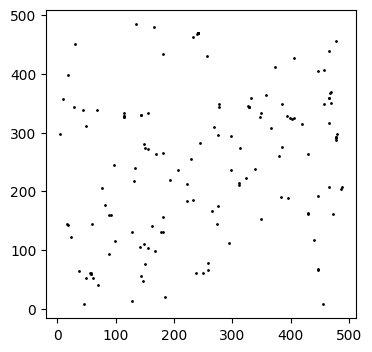

In [68]:
basic = mat_aqua["res"]["fts1"]["basic"]
# center coordinates of the event
list_event_center = np.array(basic["center"])[:, 0:2, 0]

plt.figure(figsize=(4, 4))
plt.scatter(list_event_center[:, 0], list_event_center[:, 1], s=1, c="black")
plt.show()

(2, 500, 146)


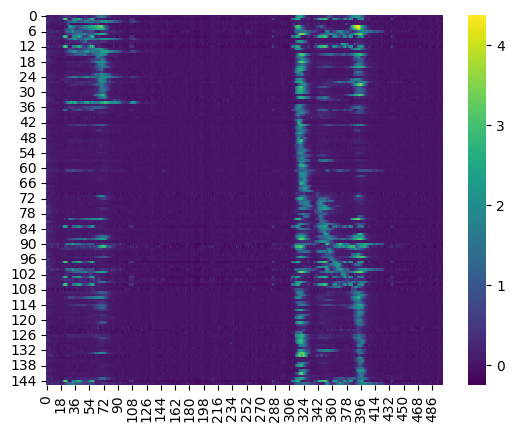

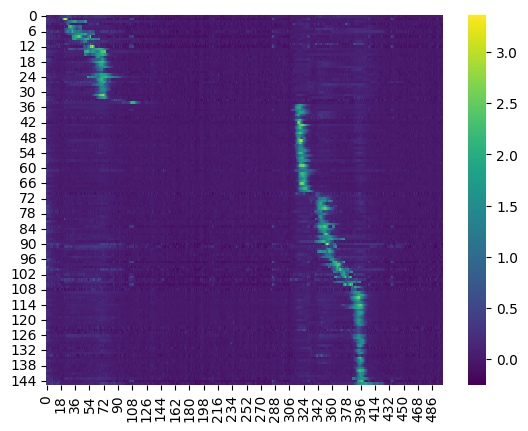

In [ ]:
# df/f0 traces of events
dffmat1 = mat_aqua["res"]["dffMat1"]
print(dffmat1.shape)

sns.heatmap(dffmat1[0].T, cmap="viridis")
plt.show()
sns.heatmap(dffmat1[1].T, cmap="viridis")
plt.show()

In [111]:
# get propagation data
propagation = mat_aqua["res"]["fts1"]["propagation"]

print(propagation.keys())

dict_keys(['areaChange', 'areaChangeRate', 'areaFrame', 'avgPropSpeed', 'maxPropSpeed', 'propGrow', 'propGrowOverall', 'propMaxSpeed', 'propShrink', 'propShrinkOverall'])


In [112]:
propagation["propGrow"]

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         1.59027779, 0.        , 0.        , 0.28885126, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.06431484,
         0.11495686, 0.39934087, 0.49500918, 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.34355187, 0.0503875 , 0.11458337, 0.        , 0.        ,
         0.08361483, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.02536231, 0.        , 0.        , 0.        ,
         0.        , 0.04464281, 0.02619052, 0.        , 0.02945733,
         0.05943155, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0

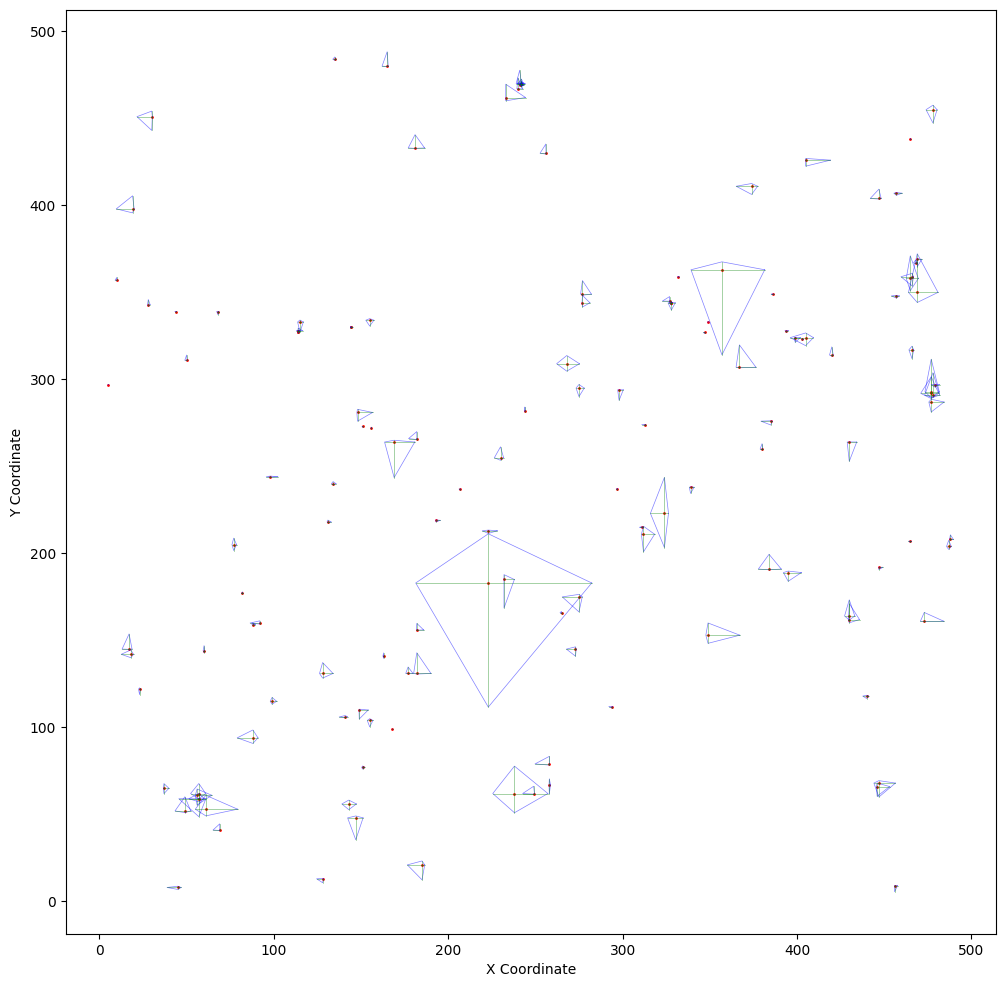

In [109]:
propGrowOverall = propagation["propGrowOverall"]

plt.figure(figsize=(12, 12))
for i, (center, prop_grow) in enumerate(zip(list_event_center, propGrowOverall.T)):
    plt.scatter(center[0], center[1], s=1, c="red", label="Event Center")
    contours = [center + np.array([prop_grow[0], 0]),
                center + np.array([0, prop_grow[2]]),
                center + np.array([-prop_grow[1], 0]),
                center + np.array([0, -prop_grow[3]]),
                center + np.array([prop_grow[0], 0]),]
    plt.plot(*zip(*contours), color="blue", alpha=0.5, linewidth=0.5)
    for contour in contours[:-1]:
        plt.plot([center[0], contour[0]], [center[1], contour[1]], color="green", alpha=0.5, linewidth=0.5)
    
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()